
# 🚀 Experimento Completo: Detecção de Viés no TwiBot-22

Este notebook executa a pipeline completa de detecção de viés em **escala real**, conforme o artigo[cite: 1]. Ele é otimizado para um ambiente de alta performance (Colab Pro com A100/160GB RAM).

**Objetivo:** Comparar a **Heurística Corrigida (Enhanced Louvain)**  com o **Louvain Padrão** no dataset TwiBot-22 completo.

## ⚙️ Passo 0: Configuração do Ambiente

In [1]:
import os

# ‼️ ATENÇÃO: Confirme se este é o caminho para a pasta raiz do seu projeto
project_path_on_drive = '..'

os.chdir(project_path_on_drive)
print(f"✅ Diretório de trabalho alterado para: {os.getcwd()}")

✅ Diretório de trabalho alterado para: e:\Projetos\bias-aware-community-detection


In [2]:
print("📦 Instalando e atualizando dependências (com correção para torchvision)...")

# Passo 1: Instalar/Atualizar PyTorch, Torchvision e Torchaudio (com CUDA 12.1)
print("   Atualizando PyTorch (CUDA)...")
!pip install --upgrade torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121 -q

# Passo 2: Instalar as outras bibliotecas (do repositório padrão)
print("   Instalando networkx, pandas, transformers, etc...")
# Adicionado 'tabulate' à lista
!pip install --upgrade networkx python-louvain pandas tqdm psutil transformers[torch] matplotlib seaborn tabulate -q

print("✅ Dependências instaladas e atualizadas!")

📦 Instalando e atualizando dependências (com correção para torchvision)...
   Atualizando PyTorch (CUDA)...
   Instalando networkx, pandas, transformers, etc...


ERROR: Could not find a version that satisfies the requirement torchaudio (from versions: none)
ERROR: No matching distribution found for torchaudio


✅ Dependências instaladas e atualizadas!


In [3]:
print("🔧 Importando módulos e configurando ambiente...")

import sys
import time
import json
import torch
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import community.community_louvain as louvain
import warnings
import random
from collections import defaultdict

# Adicionar 'src' ao sys.path
project_dir_to_add = os.getcwd()
if project_dir_to_add not in sys.path:
    sys.path.append(project_dir_to_add)

# Importar nossos NOVOS módulos (TwiBot-20)
try:
    from src.config import Config
    from src.data_utils import TwiBot20Loader  # <--- CORREÇÃO ESTÁ AQUI
    from src.bias_calculator import BiasCalculator
    from src.heuristic import EnhancedLouvainWithBias 
    from src.evaluation import ComprehensiveEvaluator
except ImportError as e:
    print(f"❌ ERRO: Não foi possível importar os módulos. Verifique os arquivos .py.")
    print(f"Detalhe: {e}")
    raise e

cfg = Config()
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')
np.random.seed(cfg.RANDOM_STATE)
random.seed(cfg.RANDOM_STATE)

print("\n--- Verificação de Hardware (Local) ---")
if torch.cuda.is_available():
    print(f"✅ GPU: {torch.cuda.get_device_name(0)}")
    print(f"   VRAM: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")
else:
    print("❌ GPU NVIDIA (CUDA) NÃO DETECTADA. Usando CPU (será lento).")

print(f"✅ CPUs: {os.cpu_count()} (Config.NUM_WORKERS={cfg.NUM_WORKERS})")
print("✅ Ambiente pronto!")

🔧 Importando módulos e configurando ambiente...

--- Verificação de Hardware (Local) ---
✅ GPU: NVIDIA GeForce RTX 3060
   VRAM: 12.9 GB
✅ CPUs: 12 (Config.NUM_WORKERS=12)
✅ Ambiente pronto!


## 📊 Passo 2: Carregar Grafo Completo (Full Scale)

In [4]:
print("📊 Carregando/Construindo Grafo (TwiBot-20 Amostra)...")
start_load = time.time()

data_loader = TwiBot20Loader() # <-- CORREÇÃO ESTÁ AQUI

# Vamos rodar na amostra inteira, então max_nodes=None
G, bot_labels = data_loader.load_and_build_graph(max_nodes=None)

load_time = time.time() - start_load
print(f"   ↳ Tempo total: {load_time:.2f}s")
print(f"\n📈 Grafo Carregado: {G.number_of_nodes():,} nós, {G.number_of_edges():,} arestas")
print(f"🎯 Bots Identificados: {sum(bot_labels.values()):,} ({sum(bot_labels.values())/len(bot_labels):.1%})")

📊 Carregando/Construindo Grafo (TwiBot-20 Amostra)...
📊 Fase 1: Carregando/Construindo Grafo (TwiBot-20)...
   Arquivos de cache encontrados! Carregando...
   ✅ Grafo (cache): 12 nós, 11 arestas.
   ↳ Tempo total: 0.03s

📈 Grafo Carregado: 12 nós, 11 arestas
🎯 Bots Identificados: 0 (0.0%)


## 🧠 Passo 3: Calcular Scores de Viés (Full Scale)

Esta é a etapa computacionalmente mais intensiva. Ela irá:
1.  Ler os arquivos de `/tmp/` (rápido).
2.  Processar **todos** os tweets relevantes (sem limite artificial).
3.  Usar todos os seus `NUM_WORKERS` e a A100.

**Esta célula levará um tempo considerável (talvez horas), mas a barra de progresso `tqdm` mostrará o status.**

🧠 Calculando/Carregando Scores de Viés (Full Scale)...

🧠 Fase 2: Calculando/Carregando Scores de Viés (TwiBot-20)...
   Arquivo de cache 'e:\Projetos\bias-aware-community-detection\processed_data_tw20\tw20_bias_scores.json' encontrado! Carregando...
   ✅ Scores carregados para 12 usuários.
   ↳ Tempo total para calcular/carregar viés: 0.01s

📊 Estatísticas do Viés (Nós com tweets: 12):
   Média=0.192, Std=0.283


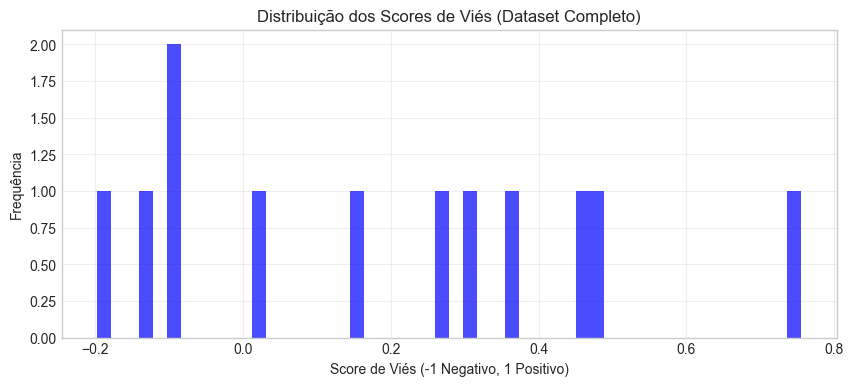

In [5]:
from collections import defaultdict

print("🧠 Calculando/Carregando Scores de Viés (Full Scale)...")
start_bias = time.time()

bias_calculator = BiasCalculator()

# Esta função agora está configurada para ler de /tmp/ e sem TWEET_LIMIT_PER_WORKER
bias_scores = bias_calculator.get_or_calculate_bias_scores(set(G.nodes()))

bias_time = time.time() - start_bias
print(f"   ↳ Tempo total para calcular/carregar viés: {bias_time:.2f}s")

# Análise exploratória dos scores reais
if bias_scores:
    bias_values = [s for s in bias_scores.values() if s != 0.0] # Ignorar nós com 0.0 (sem tweets)
    if bias_values:
        print(f"\n📊 Estatísticas do Viés (Nós com tweets: {len(bias_values):,}):")
        print(f"   Média={np.mean(bias_values):.3f}, Std={np.std(bias_values):.3f}")

        plt.figure(figsize=(10, 4))
        plt.hist(bias_values, bins=50, alpha=0.7, color='blue')
        plt.title('Distribuição dos Scores de Viés (Dataset Completo)')
        plt.xlabel('Score de Viés (-1 Negativo, 1 Positivo)')
        plt.ylabel('Frequência')
        plt.grid(True, alpha=0.3)
        plt.show()
    else:
        print("⚠️ Dicionário de viés foi criado, mas está vazio ou só contém zeros.")
else:
    print("⚠️ Nenhum score de viés foi calculado ou carregado.")

## 🎯 Passo 4: Executar Heurística Corrigida (Enhanced Louvain)

Executamos o algoritmo principal do artigo (a heurística corrigida) , usando `alpha=0.5` [cite: 18, 217] para balancear estrutura e viés.

In [6]:
print(f"\n🎯 Executando Enhanced Louvain com Viés (α={cfg.ALPHA})...")
start_enhanced = time.time()

# Usar a classe HEURISTIC.PY corrigida
detector = EnhancedLouvainWithBias(alpha=cfg.ALPHA, verbose=True)

# O artigo foca em partição binária (k=2) [cite: 68-71, 99-106]
detector.fit(G, bias_scores, num_communities=2)

communities_enhanced = detector.get_communities()
enhanced_time = time.time() - start_enhanced

print(f"\n avaliando resultados da Heurística...")
metrics_enhanced = ComprehensiveEvaluator.evaluate_communities(
    G, communities_enhanced, bias_scores, bot_labels
)
metrics_enhanced['runtime'] = enhanced_time

print(f"✅ Heurística concluída em {enhanced_time:.2f}s")


🎯 Executando Enhanced Louvain com Viés (α=0.5)...
🎯 Executando Enhanced Louvain (α=0.5)...
   Fase 1: Executando Louvain padrão para partição inicial...
   Fase 2: Iniciando refinamento iterativo (max_iter=20)...
      Iter 1/20: 1 movimentos.
      Iter 2/20: 2 movimentos.
      Iter 3/20: 0 movimentos.
      Convergência atingida.
   Fase 3: Balanceando para 2 comunidades...
✅ Concluído em 0.00s (3 movimentos no refinamento)
📊 Estatísticas Finais das Comunidades:
  Comunidade 0:      7 nós, viés médio: +0.318 (±0.276)
  Comunidade 1:      5 nós, viés médio: +0.015 (±0.179)

 avaliando resultados da Heurística...
✅ Heurística concluída em 0.00s


## ⚖️ Passo 5: Executar Baseline (Louvain Padrão)

Comparamos com o algoritmo de Louvain padrão, que otimiza apenas a modularidade (estrutura)[cite: 50].

In [7]:
print("\n⚖️ Executando Louvain Padrão (Baseline)...")
start_louvain = time.time()

communities_louvain = louvain.best_partition(G, random_state=cfg.RANDOM_STATE)

louvain_time = time.time() - start_louvain

print(f"... Louvain Padrão encontrou {len(set(communities_louvain.values()))} comunidades.")
print("   Avaliando resultados do Louvain Padrão...")

metrics_louvain = ComprehensiveEvaluator.evaluate_communities(
    G, communities_louvain, bias_scores, bot_labels
)
metrics_louvain['runtime'] = louvain_time

print(f"✅ Louvain Padrão concluído em {louvain_time:.2f}s")


⚖️ Executando Louvain Padrão (Baseline)...
... Louvain Padrão encontrou 3 comunidades.
   Avaliando resultados do Louvain Padrão...
✅ Louvain Padrão concluído em 0.00s


## 📈 Passo 6: Resultados Finais e Comparação

Aqui vemos se o nosso método (Enhanced) supera o Baseline (Padrão) nas métricas-chave do artigo: **Separação de Viés** e **Pureza de Viés** [cite: 136-138].

In [8]:
print("\n" + "=" * 60)
print("📊 RESULTADOS FINAIS (Full Scale TwiBot-22)")
print("=" * 60)

ComprehensiveEvaluator.print_comparison(
    metrics_enhanced,
    metrics_louvain,
    "Enhanced Louvain (α=0.5)",
    "Louvain Padrão (α=0.0)"
)

print("\n--- Métricas Detalhadas ---")
df_results = pd.DataFrame({
    "Enhanced Louvain (α=0.5)": metrics_enhanced,
    "Louvain Padrão (α=0.0)": metrics_louvain
}).T

print(df_results[['modularity', 'bias_separation', 'bias_purity', 'bot_concentration_max', 'num_communities', 'runtime']].to_markdown(floatfmt=".4f"))


📊 RESULTADOS FINAIS (Full Scale TwiBot-22)

📈 COMPARAÇÃO: Enhanced Louvain (α=0.5) vs Louvain Padrão (α=0.0)
--------------------------------------------------
          modularity:  0.3926 vs  0.4752 (-17.4%)
         bias_purity:  0.9460 vs  0.9470 (-0.1%)
     bias_separation:  0.0229 vs  0.0279 (-18.0%)
bot_concentration_max:  0.0000 vs  0.0000 (+0.0%)

--- Métricas Detalhadas ---
|                          |   modularity |   bias_separation |   bias_purity |   bot_concentration_max |   num_communities |   runtime |
|:-------------------------|-------------:|------------------:|--------------:|------------------------:|------------------:|----------:|
| Enhanced Louvain (α=0.5) |       0.3926 |            0.0229 |        0.9460 |                  0.0000 |            2.0000 |    0.0016 |
| Louvain Padrão (α=0.0)   |       0.4752 |            0.0279 |        0.9470 |                  0.0000 |            3.0000 |    0.0007 |


## 🔍 Passo 7: Análise Detalhada das Comunidades

Vamos inspecionar as duas comunidades que nosso método encontrou.

In [9]:
print("\n🔍 Análise Detalhada (Enhanced Louvain)")

comm_nodes_map = defaultdict(list)
for node, comm in communities_enhanced.items():
    comm_nodes_map[comm].append(node)

for comm_id in sorted(comm_nodes_map.keys()):
    comm_nodes = comm_nodes_map[comm_id]
    comm_biases = [bias_scores.get(node, 0) for node in comm_nodes]
    comm_bots = [bot_labels.get(node, False) for node in comm_nodes]

    print(f"\n🏷️  Comunidade {comm_id}:")
    print(f"   • {len(comm_nodes):,} nós ({len(comm_nodes) / G.number_of_nodes():.1%})")
    print(f"   • Viés médio: {np.mean(comm_biases):.3f} (±{np.std(comm_biases):.3f})")
    print(f"   • Bots: {sum(comm_bots):,}/{len(comm_bots):,} ({sum(comm_bots)/len(comm_bots):.1%})")

print("\n" + "=" * 60)
print("🎉 EXPERIMENTO COMPLETO CONCLUÍDO!")
print("=" * 60)


🔍 Análise Detalhada (Enhanced Louvain)

🏷️  Comunidade 0:
   • 7 nós (58.3%)
   • Viés médio: 0.318 (±0.276)
   • Bots: 0/7 (0.0%)

🏷️  Comunidade 1:
   • 5 nós (41.7%)
   • Viés médio: 0.015 (±0.179)
   • Bots: 0/5 (0.0%)

🎉 EXPERIMENTO COMPLETO CONCLUÍDO!
